# MLP

In [2]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslab_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslab_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

In [3]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split

filename = "data/class_credit_score/data_preparation/balancing/oversampling.csv"
file_tag = "class_credit_score"
data : DataFrame = read_csv(filename)

target = 'Credit_Score'
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'Credit_Score'], data['Credit_Score']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)

eval_metric = "accuracy"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=87689 Test#=43191
Labels=[0 1]


### PARAMETERS STUDY

MLP best for 250 iterations (lr_type=invscaling and lr=0.0005


<Figure size 600x450 with 0 Axes>

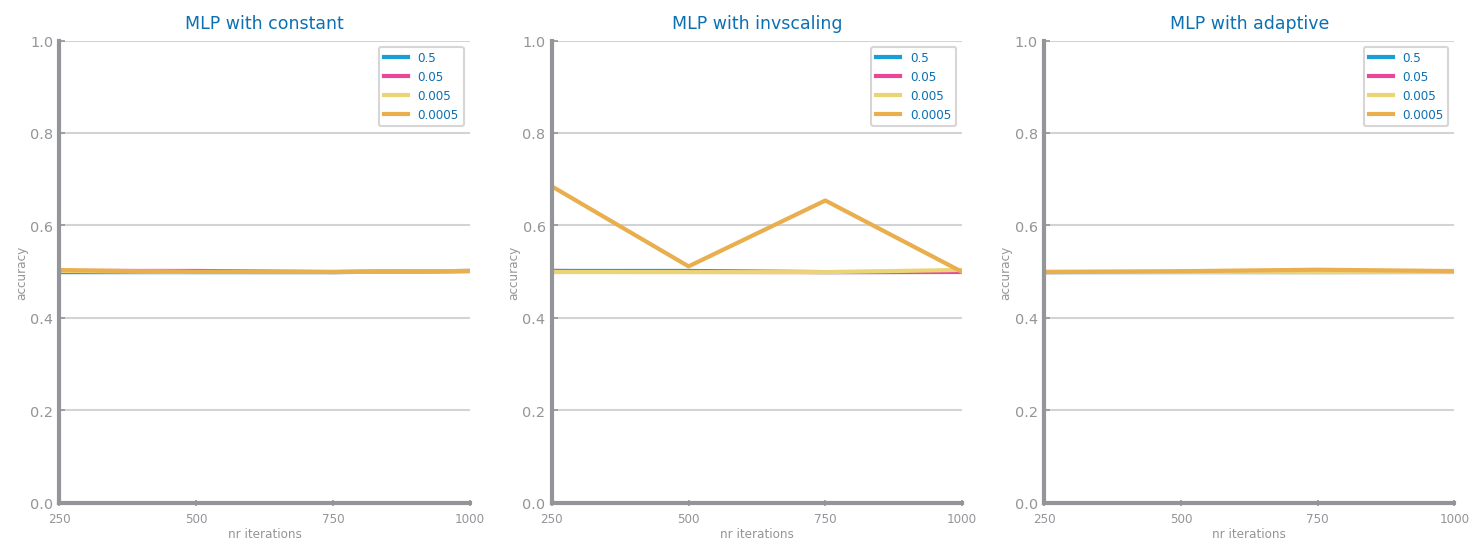

In [3]:
figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/mlp/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

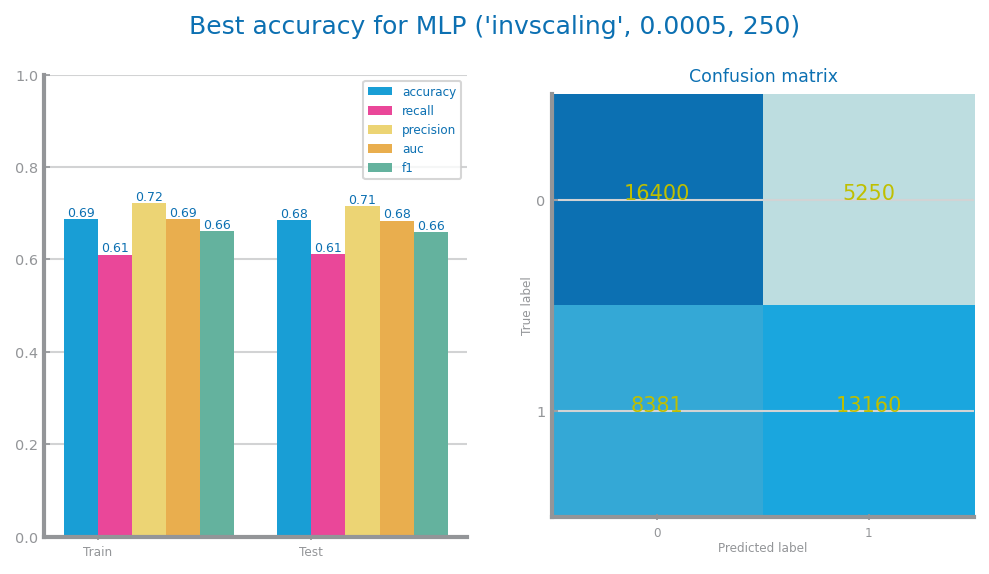

In [5]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/mlp/{params['name']}_best_{params['metric']}_eval.png")
show()

### OVERFITTING STUDY

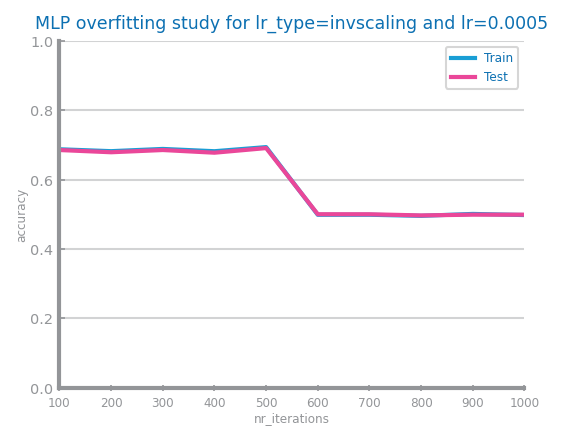

In [6]:
lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]
nr_iterations: list[int] = [i for i in range(100, 1001, 100)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/mlp/{eval_metric}_overfitting.png")

# SVM (not needed in forms)

In [7]:
from sklearn.svm import SVC

def svm_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[SVC | None, dict]:
    nr_iterations: list[int] = [100] + [
        i for i in range(500, nr_max_iterations + 1, lag)
    ]

    kernel_types: list[str] = ["linear", "poly", "rbf", "sigmoid"]
    poly_degrees: list[int] = [2, 3, 4]

    best_model = None
    best_params: dict = {"name": "SVM", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    for kernel in kernel_types:
        degrees: list[int] = poly_degrees if "poly" == kernel else [0]
        for d in degrees:
            kernel_name: str = f"poly_{d}" if "poly" == kernel else kernel
            y_tst_values: list[float] = []
            for n in nr_iterations:
                clf = SVC(kernel=kernel, max_iter=n, degree=d, verbose=False)
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (kernel, n, d)
                    best_model = clf
                # print(f'SVM lr_type={kernel_name} n={n} -> {eval}')
            values[kernel_name] = y_tst_values
    plot_multiline_chart(
        nr_iterations,
        values,
        title=f"SVM models ({metric})",
        xlabel="nr iterations",
        ylabel=metric,
        percentage=True,
    )
    best_kernel = best_params["params"][0]
    kernel_name = (
        f'poly_{best_params["params"][2]}' if "poly" == best_kernel else best_kernel
    )
    print(f'SVM best for {kernel_name} and n={best_params["params"][1]}')

    return best_model, best_params

In [8]:
filename = "data/class_credit_score/data_preparation/balancing/oversampling.csv"
file_tag = "class_credit_score"
data : DataFrame = read_csv(filename)

target = 'Credit_Score'
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'Credit_Score'], data['Credit_Score']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)

eval_metric = "accuracy"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=87689 Test#=43191
Labels=[0 1]


### PARAMETERS STUDY

SVM best for linear and n=4500


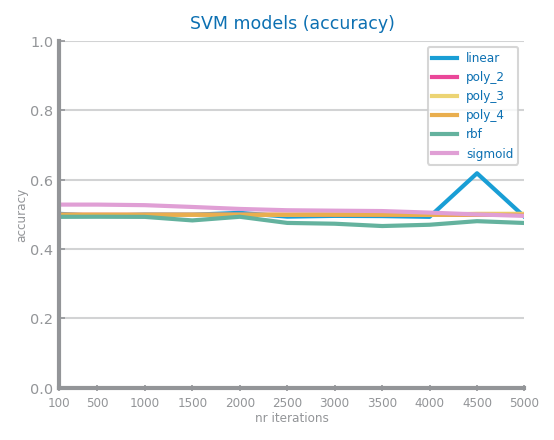

In [9]:
figure()
best_model, params = svm_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=5000,
    lag=500,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/svm/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

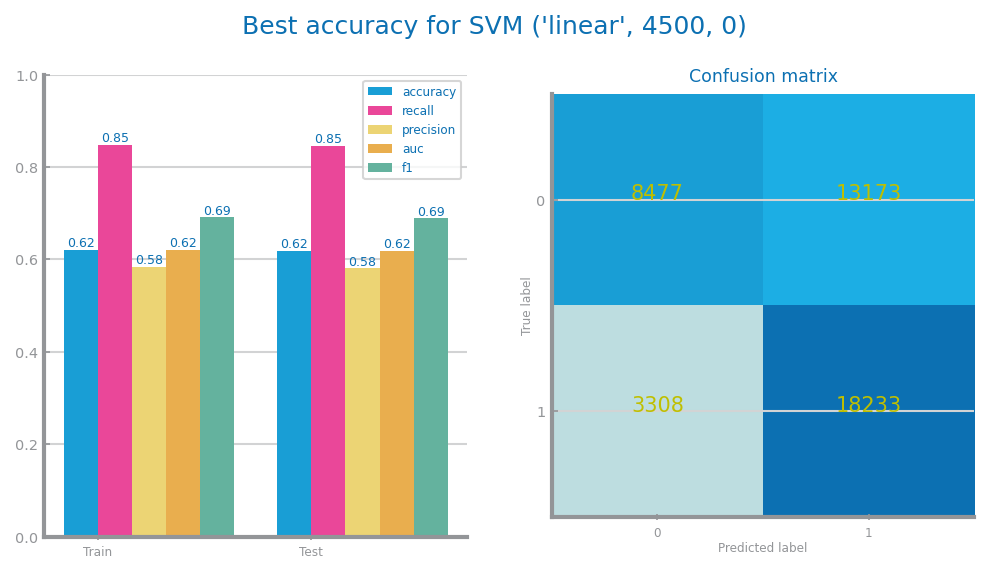

In [10]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/svm/{params['name']}_best_{params['metric']}_eval.png")
show()

### OVERFITTING STUDY

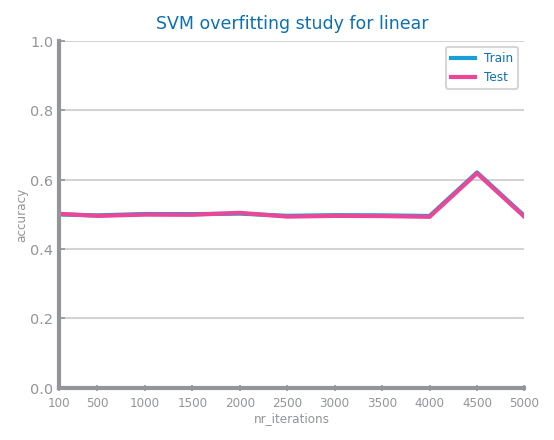

In [11]:
kernel: str = params["params"][0]
degree: int = params["params"][2]
kernel_name: str = f'poly (d={params["params"][2]})' if "poly" == kernel else kernel
nr_iterations: list[int] = [100] + [i for i in range(500, 5001, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = SVC(kernel=kernel, max_iter=n, degree=degree, verbose=False)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"SVM overfitting study for {kernel_name}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/svm/{eval_metric}_overfitting.png")

# RANDOM FORESTS

In [4]:
from sklearn.ensemble import RandomForestClassifier

def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params

In [5]:
filename = "data/class_credit_score/data_preparation/balancing/oversampling.csv"
file_tag = "class_credit_score"
data : DataFrame = read_csv(filename)

target = 'Credit_Score'
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'Credit_Score'], data['Credit_Score']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)

eval_metric = "accuracy"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=87689 Test#=43191
Labels=[0 1]


### PARAMETERS STUDY

RF best for 500 trees (d=7 and f=0.5)


<Figure size 600x450 with 0 Axes>

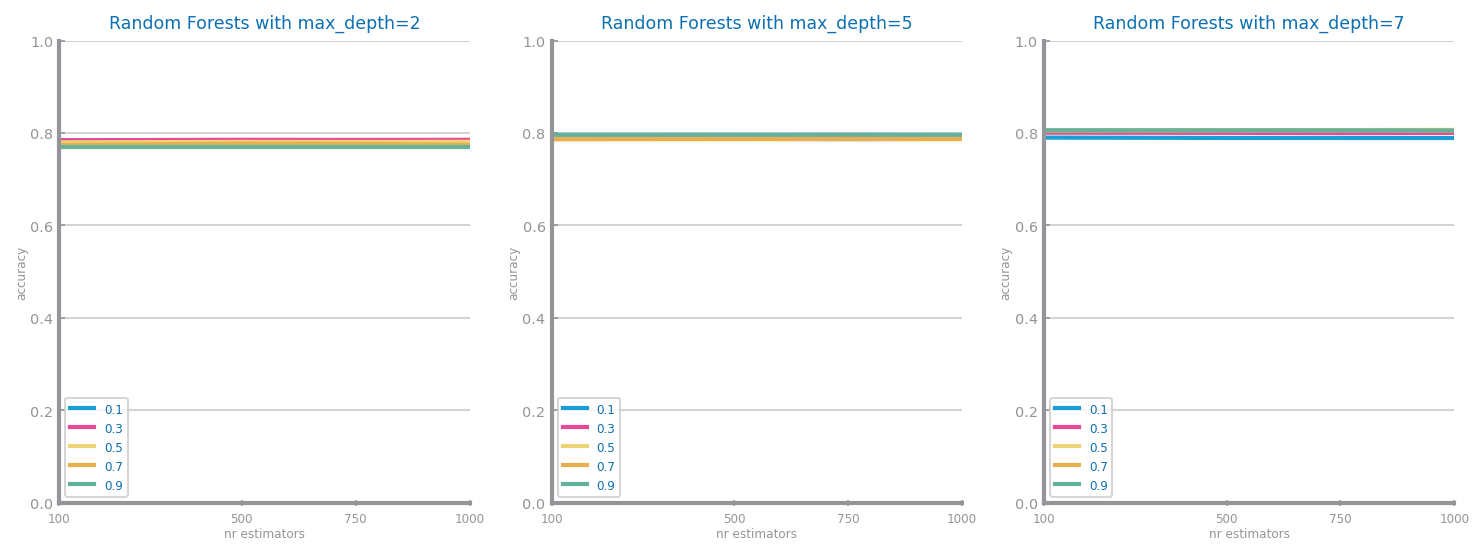

In [14]:
figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/random_forests/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

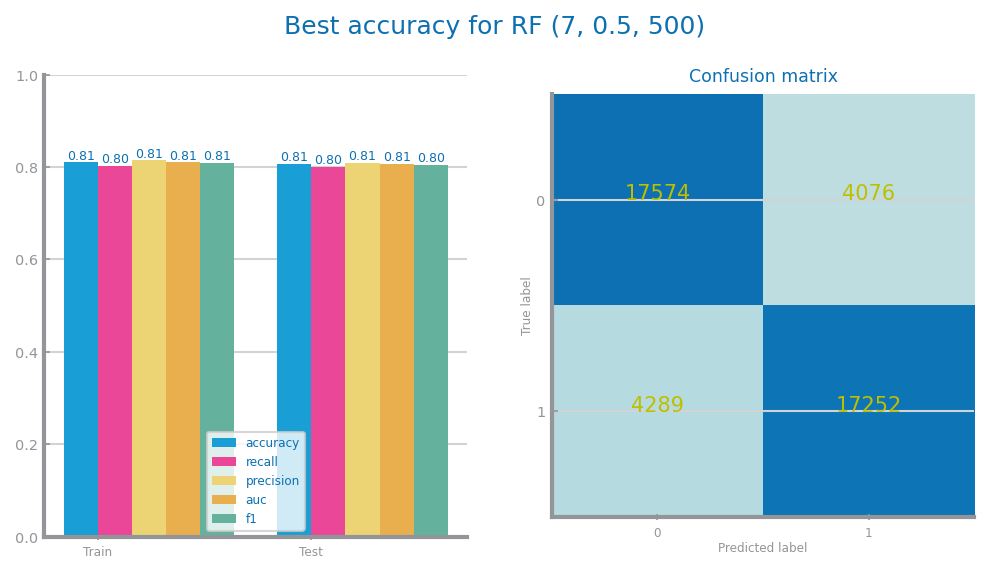

In [15]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/random_forests/{params['name']}_best_{params['metric']}_eval.png")
show()

### VARIABLES IMPORTANCE

In [6]:
vars = data.columns.tolist()
vars.remove("Credit_Score")
print(vars)

['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt', 'CreditUtilizationRatio', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance', 'Month', 'Occupation', 'CreditMix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan', 'Not Specified', 'Mortgage Loan', 'Student Loan', 'Debt Consolidation Loan', 'Payday Loan']


1. OutstandingDebt (0.44344333431308236)
2. Interest_Rate (0.2145407469925303)
3. Delay_from_due_date (0.07229071546824631)
4. NumCreditInquiries (0.07115019671462335)
5. CreditMix (0.0506706585071302)
6. ChangedCreditLimit (0.030504953577385557)
7. Num_Credit_Card (0.0251542392333548)
8. Credit_History_Age (0.024460921281598182)
9. Month (0.012326743060953263)
10. Num_Bank_Accounts (0.011109086782633778)
11. NumofLoan (0.009370396813032453)
12. NumofDelayedPayment (0.006857167117730986)
13. Annual_Income (0.005070668610113555)
14. TotalEMIpermonth (0.0035241376913934933)
15. Monthly_Inhand_Salary (0.003156068291367835)
16. Payment_of_Min_Amount (0.0023794786926136747)
17. Payment_Behaviour (0.0020422225064972415)
18. Age (0.0019465343143186048)
19. Amountinvestedmonthly (0.0016482065578210916)
20. MonthlyBalance (0.00157094866972314)
21. Occupation (0.0011237964611303958)
22. CreditUtilizationRatio (0.000890010331663819)
23. Auto Loan (0.0008133658104625745)
24. Mortgage Loan (0.00072

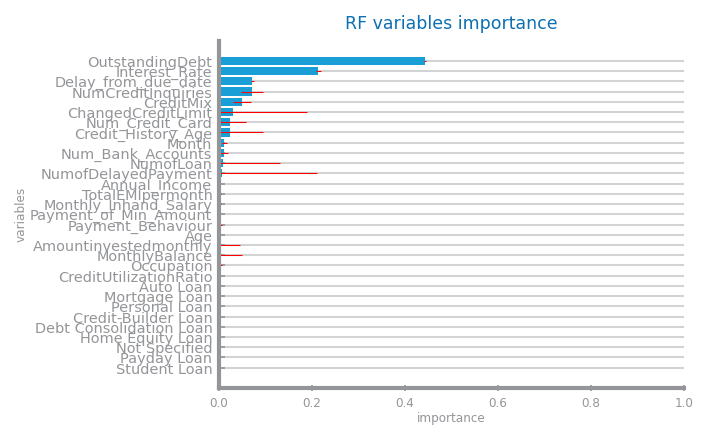

In [19]:
from numpy import std, argsort
from dslab_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/random_forests/{eval_metric}_vars_ranking.png")

### OVERFITTING STUDY

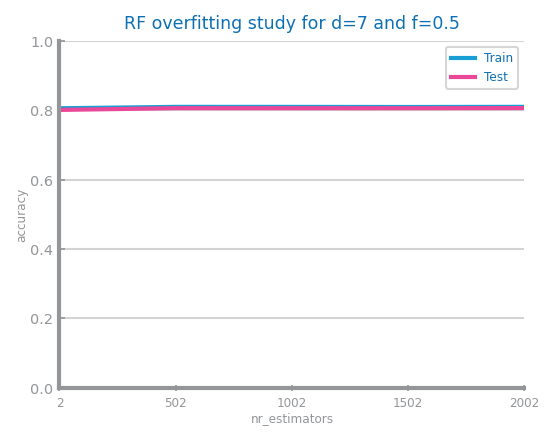

In [20]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/random_forests/{eval_metric}_overfitting.png")

# GRADIENT BOOSTING

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

In [8]:
filename = "data/class_credit_score/data_preparation/balancing/oversampling.csv"
file_tag = "class_credit_score"
data : DataFrame = read_csv(filename)

target = 'Credit_Score'
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'Credit_Score'], data['Credit_Score']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)

eval_metric = "accuracy"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=87689 Test#=43191
Labels=[0 1]


### PARAMETERS STUDY

GB best for 1000 trees (d=7 and lr=0.3


<Figure size 600x450 with 0 Axes>

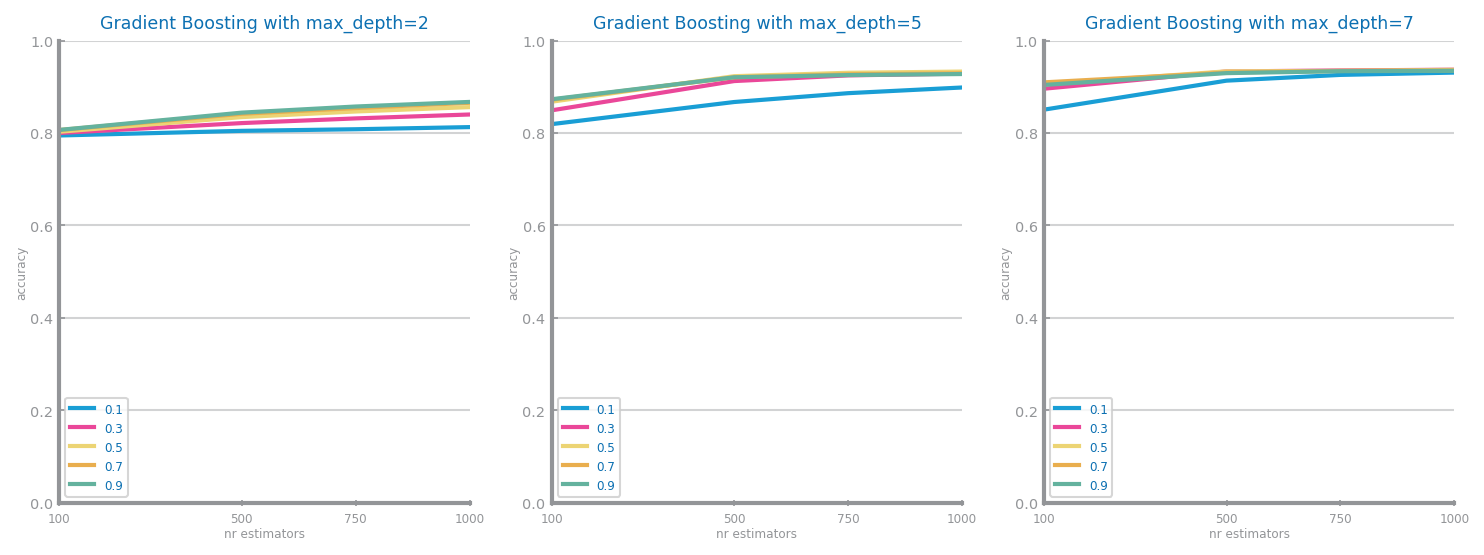

In [9]:
figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

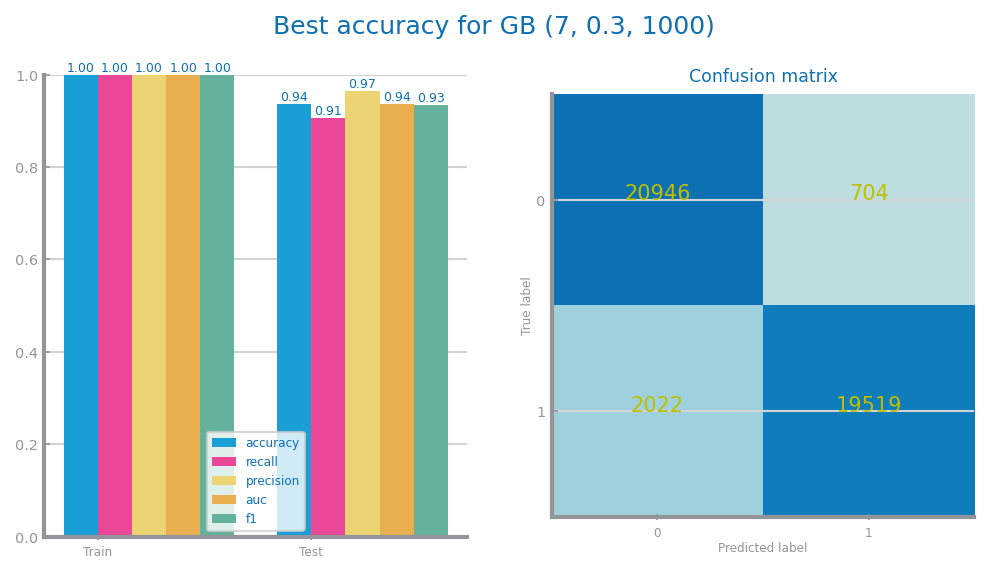

In [10]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{params['name']}_best_{params['metric']}_eval.png")
show()

### VARIABLES IMPORTANCE

1. OutstandingDebt (0.34855855650458223)
2. Interest_Rate (0.09463428838218765)
3. Delay_from_due_date (0.05589073346510575)
4. ChangedCreditLimit (0.04889459864776387)
5. Annual_Income (0.03937850181936518)
6. Credit_History_Age (0.03889207604155209)
7. TotalEMIpermonth (0.034609590726676014)
8. CreditMix (0.026877016877389096)
9. Monthly_Inhand_Salary (0.026791572544833296)
10. MonthlyBalance (0.026759679297684535)
11. Amountinvestedmonthly (0.025118104173864897)
12. CreditUtilizationRatio (0.02449820762141011)
13. Num_Credit_Card (0.024040439276636592)
14. NumofDelayedPayment (0.02190325636206146)
15. Month (0.021693432163511724)
16. Age (0.021593053259096814)
17. NumCreditInquiries (0.020292690260392102)
18. Num_Bank_Accounts (0.018310359270195507)
19. Occupation (0.014853248647306685)
20. Payment_Behaviour (0.008564514298087265)
21. NumofLoan (0.007597762836628669)
22. Auto Loan (0.0061398302229237044)
23. Personal Loan (0.005931094991240516)
24. Debt Consolidation Loan (0.0057285

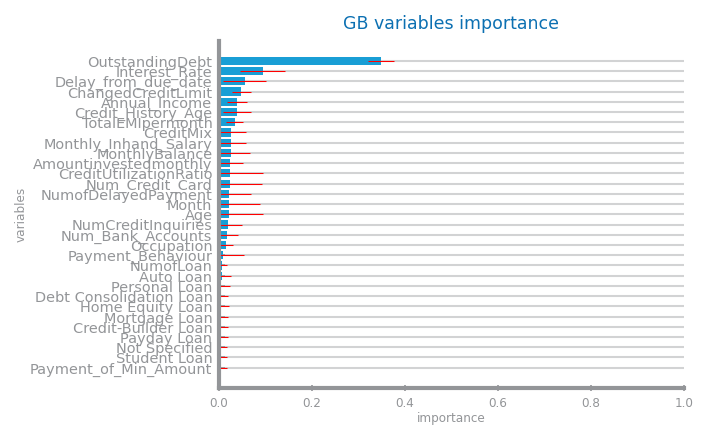

In [12]:
from numpy import std, argsort
from dslab_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{eval_metric}_vars_ranking.png")

### OVERFITTING STUDY

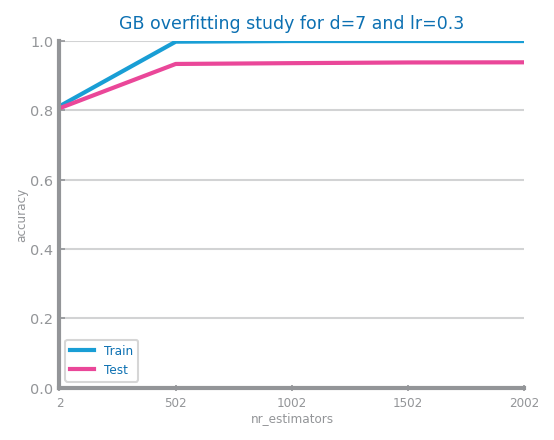

In [13]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{eval_metric}_overfitting.png")